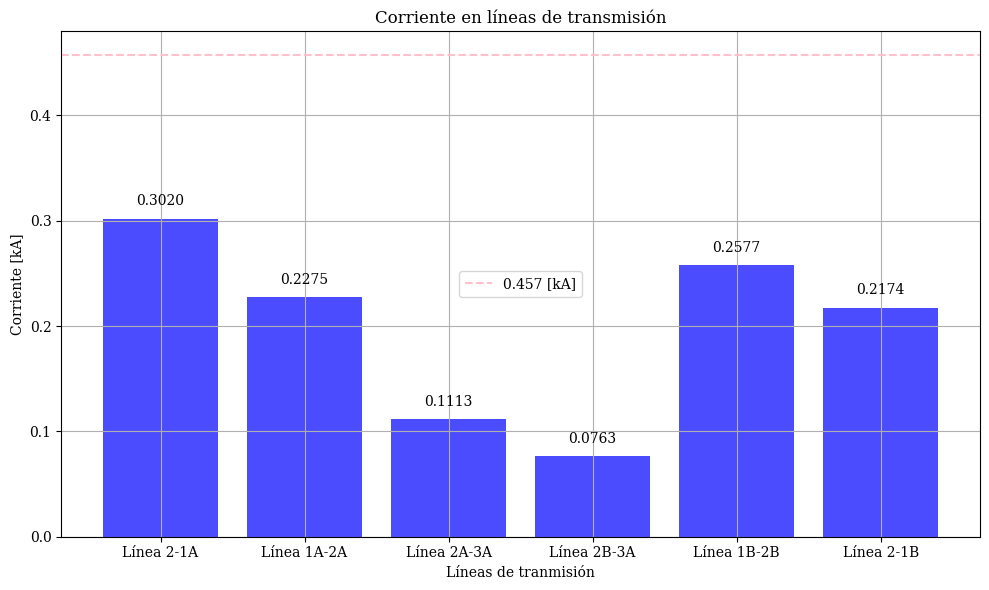

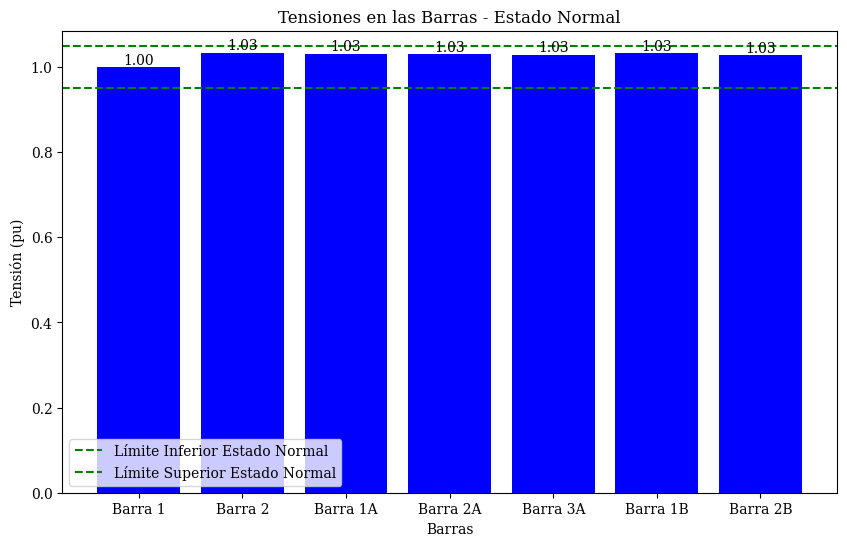

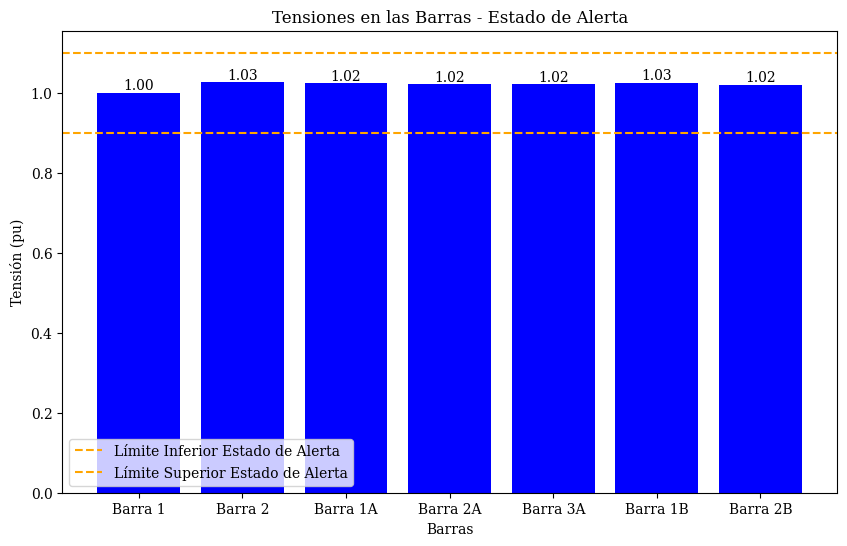

Barras fuera de norma en Estado Normal: {}
Barras fuera de norma en Estado de Alerta: {}


In [13]:

import numpy as np
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import pandapower as pp 
import math


import matplotlib.gridspec as gridscpec


pd.set_option('display.float_format', lambda x:'{:.4f}'.format(x))

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update(
    {
        'font.size':10,
        "text.usetex": False,
        "font.family": "serif",
        "font.sans-serif": ['Computer Modern'],
    }
)

#Definiendo parámetros de potencia P [MW], Q [MVA] y corriente [kA]
P=150 
Q=100
I_max= 0.457

#crear una red vacía
net = pp.create_empty_network()

#crear barras
bus1 = pp.create_bus(net, vn_kv=110, name="Barra 1")
bus2 = pp.create_bus(net, vn_kv=220, name="Barra 2")
bus1a = pp.create_bus(net, vn_kv=220, name="Barra 1A")
bus2a = pp.create_bus(net, vn_kv=220, name="Barra 2A")
bus3a = pp.create_bus(net, vn_kv=220, name="Barra 3A")
bus1b = pp.create_bus(net, vn_kv=220, name="Barra 1B")
bus2b = pp.create_bus(net, vn_kv=220, name="Barra 2B")


#crear trafo entre bus 1 y bus 2
pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, std_type="100 MVA 220/110 kV")

#crear el generador en bus1 y definirlo como la barra slack
pp.create_ext_grid(net, bus=bus1, vm_pu=1.0, va_degree=0, name="Barra Slack")

#crear cargas entre barras
pp.create_load(net, bus1a, p_mw=0.2*P, q_mvar=0.2*Q, name="Carga 1A")
pp.create_load(net, bus2a, p_mw=0.35*P, q_mvar=0.35*Q, name="Carga 2A")
pp.create_load(net, bus3a, p_mw=0.15*P, q_mvar=0.15*Q, name="Carga 3A")
pp.create_load(net, bus1b, p_mw=0.1*P, q_mvar=0.1*Q, name="Carga 1B")
pp.create_load(net, bus2b, p_mw=0.6*P, q_mvar=0.6*Q, name="Carga 2B")

#crear linea entre barras
pp.create_line(net, from_bus=bus2, to_bus=bus1a, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name='L21A', in_service=True)
pp.create_line(net, from_bus=bus1a, to_bus=bus2a, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name='L1A2A', in_service=True)
pp.create_line(net, from_bus=bus2a, to_bus=bus3a, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name='L2A3A', in_service=True)
pp.create_line(net, from_bus=bus3a, to_bus=bus2b, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name='L3A2B', in_service=True)
pp.create_line(net, from_bus=bus2, to_bus=bus1b, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name='L21B', in_service=True)
pp.create_line(net, from_bus=bus1b, to_bus=bus2b, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name='L1B2B', in_service=True)

pp.runpp(net)

line_currents = {
    'Línea 2-1A': net.res_line.at[0, 'i_ka'],
    'Línea 1A-2A': net.res_line.at[1, 'i_ka'],
    'Línea 2A-3A': net.res_line.at[2, 'i_ka'],
    'Línea 2B-3A': net.res_line.at[3, 'i_ka'],
    'Línea 1B-2B': net.res_line.at[4, 'i_ka'],
    'Línea 2-1B': net.res_line.at[5, 'i_ka'],
}

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(line_currents)), line_currents.values(), align='center', alpha=0.7, color='blue')

plt.xticks(range(len(line_currents)), line_currents.keys())

plt.xlabel('Líneas de tranmisión')
plt.ylabel('Corriente [kA]')
plt.title('Corriente en líneas de transmisión')

# Añadir los valores de cada barra en el gráfico
for i, (key, value) in enumerate(line_currents.items()):
    plt.text(i, value + 0.01, f'{value:.4f}', ha='center', va='bottom')

plt.axhline(y=I_max, color='pink', linestyle='--', label=f'{I_max} [kA]')


plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Guardar tensiones de las barras
voltages_normal = net.res_bus.vm_pu.values
bus_names = net.bus.name.values

# Comparar con los límites de tensión para Estado Normal
limits_normal = (0.95, 1.05) # Ejemplo de límites, ajustar según normativa
out_of_norm_normal = {bus: v for bus, v in zip(bus_names, voltages_normal) if not limits_normal[0] <= v <= limits_normal[1]}

# Generar gráfico de barras para Estado Normal
plt.figure(figsize=(10, 6))
bars = plt.bar(bus_names, voltages_normal, color='blue')
for bus, voltage in zip(bus_names, voltages_normal):
    plt.text(bus, voltage, f'{voltage:.2f}', ha='center', va='bottom')

for bus, bar in zip(bus_names, bars):
    if bus in out_of_norm_normal:
        bar.set_color('red')

plt.axhline(y=limits_normal[0], color='green', linestyle='--', label='Límite Inferior Estado Normal')
plt.axhline(y=limits_normal[1], color='green', linestyle='--', label='Límite Superior Estado Normal')
plt.xlabel('Barras')
plt.ylabel('Tensión (pu)')
plt.title('Tensiones en las Barras - Estado Normal')
plt.legend()
plt.show()

# Modificar condiciones para Estado de Alerta (Ejemplo: Cambiar carga o generador)
# Aquí se deberían incluir cambios relevantes para el Estado de Alerta

# Para este ejemplo, modificaremos la carga de una barra para simular el estado de alerta
net.load.at[1, 'p_mw'] *= 1.2  # Aumentar carga en la segunda carga

# Ejecutar flujo de carga para Estado de Alerta
pp.runpp(net)

# Guardar tensiones de las barras
voltages_alert = net.res_bus.vm_pu.values

# Comparar con los límites de tensión para Estado de Alerta
limits_alert = (0.90, 1.10) # Ejemplo de límites, ajustar según normativa
out_of_norm_alert = {bus: v for bus, v in zip(bus_names, voltages_alert) if not limits_alert[0] <= v <= limits_alert[1]}

# Generar gráfico de barras para Estado de Alerta
plt.figure(figsize=(10, 6))
bars = plt.bar(bus_names, voltages_alert, color='blue')
for bus, voltage in zip(bus_names, voltages_alert):
    plt.text(bus, voltage, f'{voltage:.2f}', ha='center', va='bottom')

for bus, bar in zip(bus_names, bars):
    if bus in out_of_norm_alert:
        bar.set_color('red')

plt.axhline(y=limits_alert[0], color='orange', linestyle='--', label='Límite Inferior Estado de Alerta')
plt.axhline(y=limits_alert[1], color='orange', linestyle='--', label='Límite Superior Estado de Alerta')
plt.xlabel('Barras')
plt.ylabel('Tensión (pu)')
plt.title('Tensiones en las Barras - Estado de Alerta')
plt.legend()
plt.show()

# Mostrar las barras fuera de norma
print("Barras fuera de norma en Estado Normal:", out_of_norm_normal)
print("Barras fuera de norma en Estado de Alerta:", out_of_norm_alert)
